# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the close price of the Solana cryptocurrency and the minimum threshold is 0.1

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 101 # approx 8 years
TICKER = "SOLUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.1 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:close"
TIME = f"{TICKER}:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1)

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2020-08-11 06:00:00,2.85000000,3.47000000,2.85000000,2.95150000,20032.26000000
1,2020-08-11 07:00:00,2.95150000,3.13550000,2.88000000,2.92240000,42069.37000000
2,2020-08-11 08:00:00,2.96260000,3.00000000,2.91440000,2.96000000,24280.76000000
3,2020-08-11 09:00:00,2.96000000,2.97360000,2.85000000,2.85430000,26371.23000000
4,2020-08-11 10:00:00,2.85660000,2.93290000,2.84330000,2.89760000,26685.94000000
...,...,...,...,...,...,...
41064,2025-04-18 18:00:00,133.92000000,134.20000000,133.55000000,134.00000000,53605.20200000
41065,2025-04-18 19:00:00,134.01000000,134.47000000,133.73000000,134.21000000,52051.10600000
41066,2025-04-18 20:00:00,134.21000000,134.32000000,133.48000000,134.09000000,37999.64400000
41067,2025-04-18 21:00:00,134.10000000,134.40000000,133.78000000,134.27000000,37406.54600000


In [3]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,SOLUSDT:time,SOLUSDT:high,SOLUSDT:low,SOLUSDT:close,SOLUSDT:volume
0,2020-08-11 07:00:00,6.234118,-2.422497,-0.985939,110.008107
1,2020-08-11 08:00:00,1.262405,-1.626949,-0.087761,-42.283994
2,2020-08-11 09:00:00,0.459459,-3.716216,-3.570946,8.609574
3,2020-08-11 10:00:00,2.671007,-0.465588,1.435273,1.193384
4,2020-08-11 11:00:00,6.284500,-0.521137,4.559948,-53.254298
...,...,...,...,...,...
41063,2025-04-18 18:00:00,0.209080,-0.276284,0.059737,-5.914184
41064,2025-04-18 19:00:00,0.343258,-0.208940,0.149243,-2.899151
41065,2025-04-18 20:00:00,0.081961,-0.543924,-0.089412,-26.995511
41066,2025-04-18 21:00:00,0.223714,-0.238628,0.126771,-1.560799


In [7]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
import statistics as st

close_data_processed = processed_data[f"{TICKER}:close"].to_list()
close_data_processed = close_data_processed[:-10000]
print(f"TOTAL DATAPOINTS: {len(close_data_processed)}")
print(f"MEAN CLOSE: {st.mean(close_data_processed)}")
print(f"MEDIAN CLOSE: {st.median(close_data_processed)}")

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.0: {sum(x > 0 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.1: {sum(x > 0.1 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.1 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.2: {sum(x > 0.2 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.2 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.3: {sum(x > 0.3 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.3 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.4: {sum(x > 0.4 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.4 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print("----------------------------------------------------------------------")

print("EVALUATION DATA")
close_data_processed = processed_data[f"{TICKER}:close"].to_list()
close_data_processed = close_data_processed[-10000:]
print(f"TOTAL DATAPOINTS: {len(close_data_processed)}")
print(f"MEAN CLOSE: {st.mean(close_data_processed)}")
print(f"MEDIAN CLOSE: {st.median(close_data_processed)}")

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.0: {sum(x > 0 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.1: {sum(x > 0.1 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.1 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.2: {sum(x > 0.2 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.2 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.3: {sum(x > 0.3 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.3 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.4: {sum(x > 0.4 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.4 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in close_data_processed) / len(close_data_processed), 2) * 100}%")
print("----------------------------------------------------------------------")

# close_data_processed = processed_data[f"{TICKER}:close"].to_list()

# print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in close_data_processed) / len(close_data_processed)}")
# print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

TOTAL DATAPOINTS: 31068
MEAN CLOSE: 0.022763102944825395
MEDIAN CLOSE: 0.0
MAX CLOSE IN DATASET: 30.418755529342366
OCCURRENCES OVER 0.0: 15351 - PERCENT OF DATASET: 49.0%
OCCURRENCES OVER 0.1: 13988 - PERCENT OF DATASET: 45.0%
OCCURRENCES OVER 0.2: 12579 - PERCENT OF DATASET: 40.0%
OCCURRENCES OVER 0.3: 11223 - PERCENT OF DATASET: 36.0%
OCCURRENCES OVER 0.4: 9994 - PERCENT OF DATASET: 32.0%
OCCURRENCES OVER 0.5: 8845 - PERCENT OF DATASET: 28.000000000000004%
----------------------------------------------------------------------
EVALUATION DATA
TOTAL DATAPOINTS: 10000
MEAN CLOSE: 0.007370148633670392
MEDIAN CLOSE: 0.0061002663585092015
MAX CLOSE IN DATASET: 11.864165956237581
OCCURRENCES OVER 0.0: 5009 - PERCENT OF DATASET: 50.0%
OCCURRENCES OVER 0.1: 4512 - PERCENT OF DATASET: 45.0%
OCCURRENCES OVER 0.2: 3925 - PERCENT OF DATASET: 39.0%
OCCURRENCES OVER 0.3: 3409 - PERCENT OF DATASET: 34.0%
OCCURRENCES OVER 0.4: 2896 - PERCENT OF DATASET: 28.999999999999996%
OCCURRENCES OVER 0.5: 2465

In [5]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] >= THRESHOLD: # here we use the threshold, AND APPEND THE LABEL
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,SOLUSDT:high0,SOLUSDT:low0,SOLUSDT:close0,SOLUSDT:volume0,SOLUSDT:high1,SOLUSDT:low1,SOLUSDT:close1,SOLUSDT:volume1,SOLUSDT:high2,...,SOLUSDT:volume2,SOLUSDT:high3,SOLUSDT:low3,SOLUSDT:close3,SOLUSDT:volume3,SOLUSDT:high4,SOLUSDT:low4,SOLUSDT:close4,SOLUSDT:volume4,Label
0,2020-08-11 11:00:00,6.234118,-2.422497,-0.985939,110.008107,1.262405,-1.626949,-0.087761,-42.283994,0.459459,...,8.609574,2.671007,-0.465588,1.435273,1.193384,6.284500,-0.521137,4.559948,-53.254298,1
1,2020-08-11 12:00:00,1.262405,-1.626949,-0.087761,-42.283994,0.459459,-3.716216,-3.570946,8.609574,2.671007,...,1.193384,6.284500,-0.521137,4.559948,-53.254298,9.158278,-0.029511,2.013313,996.471931,1
2,2020-08-11 13:00:00,0.459459,-3.716216,-3.570946,8.609574,2.671007,-0.465588,1.435273,1.193384,6.284500,...,-53.254298,9.158278,-0.029511,2.013313,996.471931,5.329476,-7.987785,5.329476,70.368275,0
3,2020-08-11 14:00:00,2.671007,-0.465588,1.435273,1.193384,6.284500,-0.521137,4.559948,-53.254298,9.158278,...,996.471931,5.329476,-7.987785,5.329476,70.368275,7.384024,-6.231128,-0.878397,55.447469,0
4,2020-08-11 15:00:00,6.284500,-0.521137,4.559948,-53.254298,9.158278,-0.029511,2.013313,996.471931,5.329476,...,70.368275,7.384024,-6.231128,-0.878397,55.447469,4.390904,-3.073941,-1.843134,-52.840987,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41058,2025-04-18 17:00:00,0.088942,-0.622591,-0.259413,0.299183,0.237812,-1.144471,-0.921522,-4.557556,0.142504,...,-16.954414,0.458957,-0.165526,0.383718,-66.448224,0.712091,-0.262349,0.382280,-3.606008,0
41059,2025-04-18 18:00:00,0.237812,-1.144471,-0.921522,-4.557556,0.142504,-0.645016,-0.315008,-16.954414,0.458957,...,-66.448224,0.712091,-0.262349,0.382280,-3.606008,0.209080,-0.276284,0.059737,-5.914184,1
41060,2025-04-18 19:00:00,0.142504,-0.645016,-0.315008,-16.954414,0.458957,-0.165526,0.383718,-66.448224,0.712091,...,-3.606008,0.209080,-0.276284,0.059737,-5.914184,0.343258,-0.208940,0.149243,-2.899151,0
41061,2025-04-18 20:00:00,0.458957,-0.165526,0.383718,-66.448224,0.712091,-0.262349,0.382280,-3.606008,0.209080,...,-5.914184,0.343258,-0.208940,0.149243,-2.899151,0.081961,-0.543924,-0.089412,-26.995511,1


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [8]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250603_100546"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.16 GB / 15.92 GB (26.1%)
Disk Space Avail:   119.40 GB / 475.69 GB (25.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [9]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


31063    0
31064    0
31065    0
31066    0
31067    0
        ..
41058    0
41059    0
41060    0
41061    0
41062    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.5549,
 'balanced_accuracy': 0.5144063514463536,
 'mcc': 0.051771890685901524,
 'roc_auc': 0.5487844489524534,
 'f1': 0.1678818470742195,
 'precision': 0.5364396654719236,
 'recall': 0.09951241134751773,
 'confusion_matrix':       0    1
 0  5100  388
 1  4063  449,
 'classification_report': {'0': {'precision': 0.5565862708719852,
   'recall': 0.9293002915451894,
   'f1-score': 0.696198211726162,
   'support': 5488.0},
  '1': {'precision': 0.5364396654719236,
   'recall': 0.09951241134751773,
   'f1-score': 0.1678818470742195,
   'support': 4512.0},
  'accuracy': 0.5549,
  'macro avg': {'precision': 0.5465129681719544,
   'recall': 0.5144063514463536,
   'f1-score': 0.43204002940019076,
   'support': 10000.0},
  'weighted avg': {'precision': 0.5474961225154774,
   'recall': 0.5549,
   'f1-score': 0.4578218679952055,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	112.24s	= Expected runtime (22.45s per shuffle set)
	18.06s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
SOLUSDT:close4,0.00756,0.003167,0.002966,5,0.014080,0.001040
SOLUSDT:low4,0.00536,0.001717,0.001108,5,0.008895,0.001825
SOLUSDT:close2,0.00460,0.001273,0.000637,5,0.007221,0.001979
SOLUSDT:high0,0.00424,0.001499,0.001600,5,0.007327,0.001153
SOLUSDT:low0,0.00420,0.001643,0.002318,5,0.007583,0.000817
SOLUSDT:volume3,0.00392,0.002086,0.006838,5,0.008215,-0.000375
SOLUSDT:low2,0.00380,0.002015,0.006755,5,0.007949,-0.000349
SOLUSDT:high4,0.00328,0.001460,0.003685,5,0.006286,0.000274
SOLUSDT:low1,0.00324,0.000754,0.000327,5,0.004792,0.001688
SOLUSDT:volume2,0.00308,0.001890,0.010943,5,0.006971,-0.000811


In [15]:
import re
import pandas as pd

METRIC_RE = re.compile(r":([a-zA-Z]+?)(\d+)$")   # capture metric & hour suffix


def analyze_feature_importance(feature_names, importances):
    """
    Print a short report on a model’s feature-importance vector.

    Parameters
    ----------
    feature_names : list[str]
        All feature names, e.g. ["SOLUSDT:high4", "SOLUSDT:low2", ...]
    importances : list[float]
        Matching importance values, same length/order as `feature_names`
    """
    if len(feature_names) != len(importances):
        raise ValueError("feature_names and importances must be the same length!")

    # ── Build a DataFrame ────────────────────────────────────────────────────
    df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).assign(
        metric=lambda d: d["feature"].str.extract(METRIC_RE)[0].str.lower(),
        hour=lambda d: pd.to_numeric(
            d["feature"].str.extract(METRIC_RE)[1], errors="coerce"
        ),
    )

    # Drop rows we could not parse
    df = df.dropna(subset=["metric", "hour"]).copy()
    df["hour"] = df["hour"].astype(int)

    # ── 1. % of positive importances ────────────────────────────────────────
    pct_pos = (df["importance"] > 0).mean() * 100

    # ── 2. Rank by hour (sum of importances per lag) ────────────────────────
    hour_scores = df.groupby("hour")["importance"].sum().sort_values(ascending=False)
    hour_ranking = hour_scores.index.tolist()

    # ── 3. Rank by metric (sum of importances per metric) ───────────────────
    metric_scores = (
        df.groupby("metric")["importance"].sum().sort_values(ascending=False)
    )
    metric_ranking = metric_scores.index.tolist()

    # ── Report ──────────────────────────────────────────────────────────────
    print(f"{pct_pos:.1f}% of the {len(df)} features have **positive** importance.\n")

    print("Ranking by HOUR (most → least important):")
    for i, h in enumerate(hour_ranking, 1):
        print(f"  {i}. h{h:<1}   sum importance = {hour_scores[h]:.6f}")

    print("\nRanking by METRIC (most → least important):")
    for i, m in enumerate(metric_ranking, 1):
        print(f"  {i}. {m:<6} sum importance = {metric_scores[m]:.6f}")

    top_features = (
        df.loc[df["importance"].abs().sort_values(ascending=False).index]
        .head(5)[["feature", "importance"]]
    )
    print("\nTop 5 individual features:")
    for feat, imp in top_features.itertuples(index=False):
        print(f"  {feat:<25} {imp:.6f}")




analyze_feature_importance(feature_importance.index.to_list(), feature_importance['importance'].to_list())

100.0% of the 20 features have **positive** importance.

Ranking by HOUR (most → least important):
  1. h4   sum importance = 0.017120
  2. h2   sum importance = 0.013920
  3. h0   sum importance = 0.011840
  4. h1   sum importance = 0.009120
  5. h3   sum importance = 0.008560

Ranking by METRIC (most → least important):
  1. low    sum importance = 0.016960
  2. close  sum importance = 0.015840
  3. high   sum importance = 0.014560
  4. volume sum importance = 0.013200

Top 5 individual features:
  SOLUSDT:close4            0.007560
  SOLUSDT:low4              0.005360
  SOLUSDT:close2            0.004600
  SOLUSDT:high0             0.004240
  SOLUSDT:low0              0.004200


In [10]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
#display(validation_probabilities)
#display(validation_predictions)
#display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.5)
print("COUNT OF NUMBERS > 0.5:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.55)
print("COUNT OF NUMBERS > 0.55:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.6)
print("COUNT OF NUMBERS > 0.6:", count_above_09)








MEAN PROB 1 CLASSIFICATION: 0.4398870093345642
MAX PROB 1 CLASSIFICATION: 0.6242164373397827
MIN PROB 1 CLASSIFICATION: 0.31774449348449707
COUNT OF NUMBERS > 0.5: 837
COUNT OF NUMBERS > 0.55: 108
COUNT OF NUMBERS > 0.6: 9


In [ ]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade - since this focuses on shorting the true close is multiplied by -1
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1])
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
true_closes_list = validation_dataset[f"{TICKER}:close4"].to_list()
true_close_base = 100
true_close_base_list = []

for close in true_closes_list:
    true_close_base *= 1 + (close / 100)
    true_close_base_list.append(true_close_base)


# # Create a figure with two subplots next to each other
# fig, axes = plt.subplots(ncols=2, figsize=(12, 5))  # Adjust figsize as needed

# # Plot investment history
# axes[0].plot(investment_history)
# axes[0].set_title("Investment Value Over Time")
# axes[0].set_xlabel("Time (Hours)")
# axes[0].set_ylabel("Investment Value")

# # Plot true closes
# axes[1].plot(true_close_base_list)
# axes[1].set_title("True Closes Over Time")
# axes[1].set_xlabel("Time (Hours)")
# axes[1].set_ylabel("Asset close price fluctuations")

# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10,5))
plt.plot(investment_history, label="Investment History", color='red', linewidth=2.5)
plt.plot(true_close_base_list, label="True Closes", color='gray', linewidth=1)
plt.xlabel("Trade Index")
plt.ylabel("Value")
plt.title("Investment Value and True Closes Over Trades")
plt.legend()
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

NUMBER OF TRADES: 837
ACCURACY: 52.09%
RETURN: 41.87653597770711 %
SHARPE RATIO: 1.00632528355078
SHARPE RATIO ONLY HOLDING ASSET: 0.718588769485224
MEAN win: 1.0577410981232018
MEAN loss: -1.0380516628668952


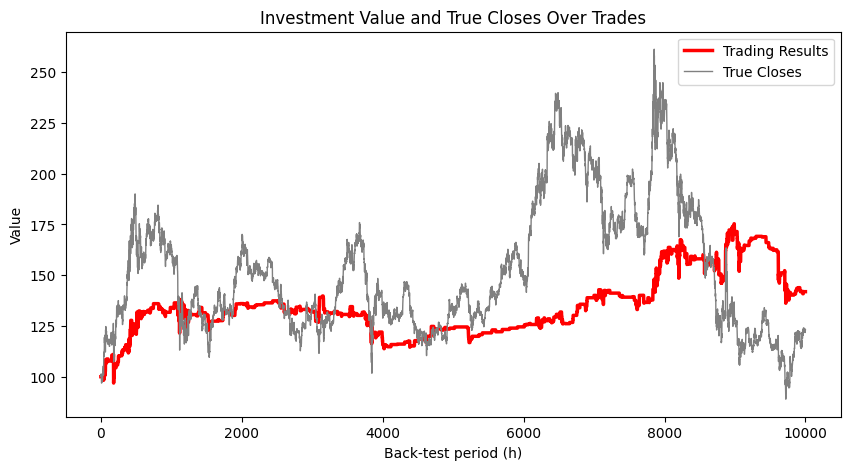

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################
from matplotlib import pyplot as plt



# --- Constants ---
MINIMUM_PROBABILITY = 0.5
TRADING_FEE = 0.0
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE # FEE AND LEVERAGE ADJUSTED FOR
        
        if true_close >= 0.0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)
        all_trades.append(0)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
#print(f"CORRECT: {correct_trades}")
#print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
#print(f"NUMBER OF TRADES 2: {len(investment_history)}")
print(f"ACCURACY: {round(win_rate, 2)}%")
print(f"RETURN: {investment_value - 100} %")
print(f"SHARPE RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARPE RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN win: {st.mean(good_trades)}")
print(f"MEAN loss: {st.mean(bad_trades)}")
#print(f"INVESTMENT VALUE {investment_value}")

# for trade in all_trades:
#     print(trade)

# --- Plot the investment history ---
true_closes_list = validation_dataset[f"{TICKER}:close4"].to_list()
true_close_base = 100
true_close_base_list = []

for close in true_closes_list:
    true_close_base *= 1 + (close / 100)
    true_close_base_list.append(true_close_base)


plt.figure(figsize=(10,5))
plt.plot(investment_history, label="Trading Results", color='red', linewidth=2.5)
plt.plot(true_close_base_list, label="True Closes", color='gray', linewidth=1)
plt.xlabel("Back-test period (h)")
plt.ylabel("Value")
plt.title("Investment Value and True Closes Over Trades")
plt.legend()
plt.show()